<a href="https://colab.research.google.com/github/ADGGi/CP1/blob/main/Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
myfile = files.upload()

Saving model_data.csv to model_data.csv


In [ ]:
#데이터 불러오기
import numpy as np
import pandas as pd

X_train = np.load('/content/drive/MyDrive/project1/dataset/arrayset/X_train.npy')
X_test = np.load('/content/drive/MyDrive/project1/dataset/arrayset/X_test.npy')

y_train = np.load('/content/drive/MyDrive/project1/dataset/arrayset/y_train.npy')
y_test = np.load('/content/drive/MyDrive/project1/dataset/arrayset/y_test.npy')

X_train_smote = np.load('/content/drive/MyDrive/project1/dataset/arrayset/X_train_smote.npy')
y_train_smote = np.load('/content/drive/MyDrive/project1/dataset/arrayset/y_train_smote.npy')

df = pd.read_csv('/content/model_data.csv')
df = df[['comments', 'label']]
print('data shape :', df.shape)

print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)

print('\nX_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

data shape : (53174, 2)
X_train shape : (42539, 400)
y_train shape : (42539,)

X_test shape : (10635, 400)
y_test shape : (10635,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

In [ ]:
train_token = pd.read_csv('/content/drive/MyDrive/project1/train_token.csv')
train_token.head()

,Unnamed: 0,comments,label,tokens
0,0,빅토리묵ㅋㅋ,0,"['빅', '토리묵', 'ㅋㅋ']"
1,1,기자들이 어떤 질문할지도 예상 했을것이고 내편이 아닌걸 알텐데 누구라도 묵묵히 들어...,0,"['기자', '들', '이', '어떤', '질문', '하', 'ㄹ지', '도', '..."
2,2,이 ㅅㄲ가 96이란다,0,"['이', 'ㅅ', 'ㄲ', '가', '96', '이', '란', '다']"
3,3,9:24 난 여기 다양한 거 보여준다는 말이 너무 웃곀ㅋㅋ,0,"['9', ':', '24', '난', '여기', '다양', '하', 'ㄴ', '거..."
4,4,참으세요 장인어른 ㅠㅠ,0,"['참으', '시', '어요', '장인', '어르', 'ㄴ', 'ㅠ', 'ㅠ']"


In [ ]:
a = train_token.tokens
a.to_numpy()

array(["['빅', '토리묵', 'ㅋㅋ']",
       "['기자', '들', '이', '어떤', '질문', '하', 'ㄹ지', '도', '예상', '하', '였', '을', '것', '이', '고', '내편', '이', '아니', 'ㄴ', '것', 'ㄹ', '알', '터', '이', 'ㄴ데', '누구', '이', '라도', '묵묵히', '들어가', 'ㄹ', '듯', '.', '그냥', '냅두', '어요', '.', '지켜보', '다', '보', '면', '밝히', '어', '지', '겠', '죠', '.']",
       "['이', 'ㅅ', 'ㄲ', '가', '96', '이', '란', '다']", ...,
       "['자꾸', '용진', '님', '집', '에서', '오', '아서', '자라', '고', '하', '는', '것', '이', '넘', '웃기', '어', 'ㅋ', 'ㅋ']",
       "['혹시', '죽', '어', '보', '신적', '도', '있', '나요', '?']",
       "['근데', '성매매', '하', '면', '기록', '남', '을', '터', '이', 'ㄴ데']"],
      dtype=object)

In [ ]:
a = pd.Series([[str(x) for x in string.strip("[]").split(',')] for string in a.tolist()])
a.to_numpy()

array([list(["'빅'", " '토리묵'", " 'ㅋㅋ'"]),
       list(["'기자'", " '들'", " '이'", " '어떤'", " '질문'", " '하'", " 'ㄹ지'", " '도'", " '예상'", " '하'", " '였'", " '을'", " '것'", " '이'", " '고'", " '내편'", " '이'", " '아니'", " 'ㄴ'", " '것'", " 'ㄹ'", " '알'", " '터'", " '이'", " 'ㄴ데'", " '누구'", " '이'", " '라도'", " '묵묵히'", " '들어가'", " 'ㄹ'", " '듯'", " '.'", " '그냥'", " '냅두'", " '어요'", " '.'", " '지켜보'", " '다'", " '보'", " '면'", " '밝히'", " '어'", " '지'", " '겠'", " '죠'", " '.'"]),
       list(["'이'", " 'ㅅ'", " 'ㄲ'", " '가'", " '96'", " '이'", " '란'", " '다'"]),
       ...,
       list(["'자꾸'", " '용진'", " '님'", " '집'", " '에서'", " '오'", " '아서'", " '자라'", " '고'", " '하'", " '는'", " '것'", " '이'", " '넘'", " '웃기'", " '어'", " 'ㅋ'", " 'ㅋ'"]),
       list(["'혹시'", " '죽'", " '어'", " '보'", " '신적'", " '도'", " '있'", " '나요'", " '?'"]),
       list(["'근데'", " '성매매'", " '하'", " '면'", " '기록'", " '남'", " '을'", " '터'", " '이'", " 'ㄴ데'"])],
      dtype=object)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_token['comments'].astype(str))
vocab=tokenizer.word_index

In [ ]:
vocab_size = len(vocab)
embedding_dim = 128
max_len = 400
n_class = 2

In [ ]:
bi_LSTM = Sequential([Embedding(vocab_size, embedding_dim, input_length = max_len),
                       Bidirectional(LSTM(64, return_sequences=True)),
                       Bidirectional(LSTM(64, return_sequences=False)),
                       Dropout(0.2),
                       Dense(1, activation='sigmoid')
])


bi_LSTM.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
bi_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 128)          14217984  
                                                                 
 bidirectional (Bidirectiona  (None, 400, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 14,415,745
Trainable params: 14,415,745
No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#교차검증
n_fold = 3
seed = 722

cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = seed)

#예측값 공간
y_prob = np.zeros((X_test.shape[0], 1))

#조기종료
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 3,
                   verbose = 1, mode = min, baseline = None, restore_best_weights=True)

k=0
for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1) :
  print('{}번째 교차검증'.format(k+1))

  bi_LSTM.fit(X_train[i_trn],
              (y_train[i_trn]),
              validation_data=(X_train[i_val], (y_train[i_val])),
              epochs = 10,
              batch_size = 256,
              callbacks=[es])
  
  y_prob += bi_LSTM.predict(X_test)
  k += 1

  


1번째 교차검증
Epoch 1/10
111/111 [==============================] - 43s 387ms/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.0704 - val_accuracy: 0.9772
Epoch 2/10
111/111 [==============================] - 43s 387ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0793 - val_accuracy: 0.9745
Epoch 3/10
111/111 [==============================] - 43s 387ms/step - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0878 - val_accuracy: 0.9719
Epoch 4/10
111/111 [==============================] - 43s 387ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.1015 - val_accuracy: 0.9709
Epoch 00004: early stopping
2번째 교차검증
Epoch 1/10
111/111 [==============================] - 43s 389ms/step - loss: 0.0474 - accuracy: 0.9844 - val_loss: 0.0304 - val_accuracy: 0.9898
Epoch 2/10
111/111 [==============================] - 43s 388ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0386 - val_accuracy: 0.9877
Epoch 3/10
111/111 [==============================] - 43s 387ms/step - loss: 0.0154 

In [ ]:
import matplotlib.pyplot as plt

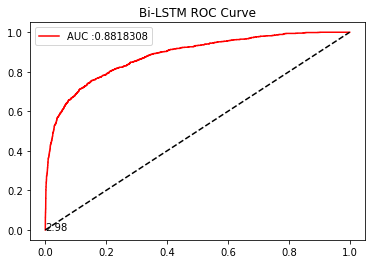

In [ ]:
fpr, tpr, thr = roc_curve(y_test, y_prob)

idx_list = np.arange(1, len(thr), 2000)

plt.plot(fpr, tpr,
        c = 'red',
        label = "AUC :"+str(round(roc_auc_score(y_test, y_prob), 7)))
plt.plot([0,1], [0,1], ls='--', c='black')
plt.title("Bi-LSTM ROC Curve")
plt.legend(loc=0)
for idx in idx_list:
  text = str(round(thr[idx], 2))
  plt.text(fpr[idx], tpr[idx], text)

In [ ]:
data = {'fpr' : fpr,
        'tpr' : tpr,
        'thr' : thr}

dff = pd.DataFrame(data)

dff.to_csv('/content/drive/MyDrive/project1/DeepLearning/bi_lstm_roc_curve')

In [ ]:
bi_LSTM.save('bi_lstm.h5')